# Plot for Summary Report: Regression Analysis

In [2]:
%run 'helpers-for-report-plot-generation.ipynb'

In [3]:
def get_data():
    """Get raw data from local database"""
    milk = get_dataset('milk_volume')
    birthdates = get_dataset('birthdates')
    genetics = get_dataset('genetics')
    classification = get_dataset('classification')
        
    return select_milk_features(milk), \
           select_birthdate_features(birthdates), \
           select_genetics_features(genetics), \
           select_classification_features(classification)
    
def select_milk_features(milk):
    """Prepare and select milk features"""
    
    milk = milk.rename(columns={'date':'milk_date'})
    milk = milk.dropna(axis=0, how='any')
    milk = milk.sort_values(['milk_date', 'animal_id']).reset_index()
    
    features = ['animal_id', 'milk_date', 'milk_weight', 'days_since_calving']
    return milk[features]

def select_birthdate_features(birthdates):
    """Prepare and select birthdate features"""
    
    birthdates = birthdates.sort_values(['birthdate']).reset_index()
    
    features = ['animal_id', 'birthdate']
    return birthdates[features]

def select_genetics_features(genetics):
    """Prepare and select genetics features"""
    genetics = genetics.rename(columns={'milk':'milk_score'})
    
    features = ['animal_id', 'milk_score', 'ctpi']
    return genetics[features]

def select_classification_features(classifications):
    """Prepare and select genetics features"""
    
    classifications = classifications.sort_values(['animal_id', 'date'])
    classifications = classifications.drop_duplicates(subset=['animal_id'], keep='last').reset_index()
    
    features = ['animal_id', 'dairy_form', 'udder_score_aggregate', 'dairy_strength_aggregate', \
                'final_score', 'breed_age_average']
    return classifications[features]

In [4]:
def build_annual_performance_profiles(milk, birthdates):
    """Takes milk data and and calculates the performance profiles of each animal by calendar year."""
    years = milk['milk_date'].dt.year.unique()
    profiles = []
    
    for year in years:
        year_mask = (milk['milk_date'].dt.year == year)
        milk_for_year = milk[year_mask]
        
        for animal_id in milk['animal_id'].unique():    
            animal_milk_for_year = milk_for_year[milk_for_year['animal_id'] == animal_id]
            
            profile = {}
            profile['animal_id'] = animal_id
            profile['year'] = year
            
            profile['days_milked'] = animal_milk_for_year.count()['animal_id']
            if profile['days_milked'] == 0:
                profile['days_milked'] = np.NaN
            
            profile['total_milkweight'] = animal_milk_for_year['milk_weight'].sum()
            if profile['total_milkweight'] == 0:
                 profile['total_milkweight'] = np.NaN
            
            profile['milkweight_per_day'] = animal_milk_for_year['milk_weight'].mean()
            if profile['total_milkweight'] == 0:
                profile['total_milkweight'] = np.NaN
            
            profiles.append(profile)
         
    data = pd.DataFrame(profiles)
    data.describe()
    data = data.sort_values(['year', 'animal_id', 'milkweight_per_day']).reset_index()
    features = ['year', 'animal_id', 'days_milked', 'milkweight_per_day', 'total_milkweight']
    return data[features]

In [5]:
def append_previous_year_profiles_to_milk_data(milk, profiles):
    """For each milk_date, animal_id combination, retrieve the profile from the previous year and merge to dataframe"""
    
    milk['prior_year'] = milk['milk_date'].dt.year - 1
    milk = milk.set_index(['milk_date'])['2016-01-01':'2017-12-31'].reset_index()
    
    data = pd.merge(left=milk, right=profiles, left_on=['prior_year', 'animal_id'], right_on=['year', 'animal_id'])
    features = ['milk_date', 'animal_id', 'milk_weight', 'days_since_calving', 'milkweight_per_day']
    
    return data[features].rename(columns={'milkweight_per_day':'prior_year_milkweight_per_day'})

In [6]:
def append_months_aged_to_milk_data(milk, birthdates):
    """Calcualte the number of months aged for on each milking date"""
    data = pd.merge(left=milk, right=birthdates, left_on='animal_id', right_on='animal_id')
    data['age_in_months'] = (data['milk_date'] - data['birthdate']).astype('timedelta64[M]')
    
    features = ['milk_date', 'animal_id', 'milk_weight', 'age_in_months', \
                'prior_year_milkweight_per_day', 'days_since_calving']
    return data[features]

In [7]:
def aggregate_data_for_regression(milk, genetics, classification):
    """Merge Genetics, Milk, and Classification Data Sets"""
    data = pd.merge(left=milk, right=genetics, left_on='animal_id', right_on='animal_id')
    data = pd.merge(left=data, right=classification, left_on='animal_id', right_on='animal_id')    
    return data

In [8]:
def get_data_for_analysis():
    milk, birthdates, genetics, classification = get_data()
    profiles = build_annual_performance_profiles(milk, birthdates)
    milk = append_previous_year_profiles_to_milk_data(milk, profiles)
    milk = append_months_aged_to_milk_data(milk, birthdates)
    return aggregate_data_for_regression(milk, genetics, classification)

data = get_data_for_analysis()
data = data.dropna()
data = data[data['days_since_calving'] < 305]
data.sample(10)

,milk_date,animal_id,milk_weight,age_in_months,prior_year_milkweight_per_day,days_since_calving,milk_score,ctpi,dairy_form,udder_score_aggregate,dairy_strength_aggregate,final_score,breed_age_average
50147,2016-05-24,1922,82.2,52.0,56.921583,127.0,-858,1479,42.0,86.0,91.0,86.0,107.199997
43033,2017-03-02,2081,112.5,38.0,67.776023,35.0,330,1648,25.0,74.0,83.0,77.0,99.800003
3759,2017-02-13,1807,112.8,75.0,68.201661,42.0,-407,1488,22.0,82.0,82.0,81.0,101.599998
60044,2017-04-14,2118,111.1,35.0,71.484211,21.0,236,1936,33.0,81.0,86.0,82.0,105.500000
10163,2017-04-24,1883,86.2,68.0,73.479211,118.0,158,1695,32.0,87.0,88.0,86.0,107.199997
10335,2016-01-17,1884,104.9,53.0,81.430709,25.0,202,1689,41.0,82.0,87.0,85.0,106.000000
38841,2016-06-16,2069,53.1,31.0,67.651899,248.0,-122,1468,28.0,76.0,84.0,80.0,103.199997
41879,2017-05-13,2076,73.0,41.0,77.570492,198.0,906,1948,32.0,75.0,81.0,76.0,98.400002
46468,2017-05-03,2091,51.4,40.0,83.354430,136.0,1350,1744,39.0,79.0,86.0,79.0,99.900002
23135,2016-05-16,1997,67.7,41.0,68.464516,199.0,-134,1547,22.0,73.0,82.0,77.0,100.099998


In [9]:
y = data['milk_weight']
X = data.drop(axis=1, labels=['milk_weight', 'milk_date'])

In [10]:
def plot_model_scatter_plot(y_test, y_pred):

    plt.scatter(y_test, y_pred)
    plt.plot([0,350],[0,350])
    plt.xlabel('One-Day Milk Weight Actual')
    plt.ylabel('One-Day Milk Weight Predicted')
    save_plot_for_summary_report('regression-predicted-versus-actual.png')
    plt.show()
    
    residuals = (np.subtract(y_test, y_pred)) 
    normed_residuals = residuals / y_test.std()

    sns.residplot(y=normed_residuals, x=y_test)
    plt.ylabel('Residual Error')
    plt.xlabel('Fitted Values')
    save_plot_for_summary_report('regression-residual-errors.png')
    plt.show()

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Best Paremeters: {'forest__max_features': 'auto', 'forest__n_estimators': 14}
CV_Score: 0.2803263506315664


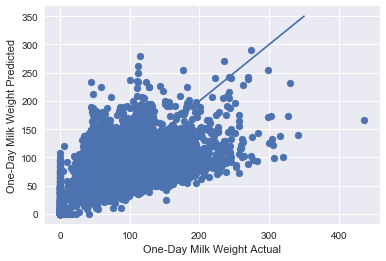

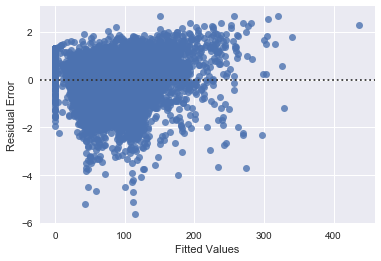

In [12]:
# Setup the pipeline steps: steps
steps = [('imputation', Imputer(missing_values='NaN', strategy='median', axis=0)), 
         ('scalar', StandardScaler()),
         ('forest', RandomForestRegressor())]

# Create the pipeline: pipeline 
pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'forest__n_estimators':np.arange(2, 15, 2),
              'forest__max_features':['auto', 'sqrt', 'log2']}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Create the GridSearchCV object: gm_cv
m_cv = GridSearchCV(pipeline, cv=3, param_grid=parameters)

# Fit to the training set
m_cv.fit(X_train, y_train)

# Compute and print the metrics
r2 = m_cv.score(X_test, y_test)
print("Best Paremeters: {}".format(m_cv.best_params_))
print("CV_Score: {}".format(r2))

y_pred = m_cv.predict(X_test)
plot_model_scatter_plot(y_test, y_pred)

In [13]:
predicted = m_cv.predict(X)

In [14]:
data['milk_weight_predicted'] = predicted
output = data[['milk_weight_predicted', 'milk_weight', 'days_since_calving', 'age_in_months', \
             'prior_year_milkweight_per_day', 'dairy_form', 'udder_score_aggregate', 'dairy_strength_aggregate', 'final_score', \
             'breed_age_average', 'milk_score', 'ctpi']]

In [15]:
output.sample(10)

,milk_weight_predicted,milk_weight,days_since_calving,age_in_months,prior_year_milkweight_per_day,dairy_form,udder_score_aggregate,dairy_strength_aggregate,final_score,breed_age_average,milk_score,ctpi
31751,112.185714,156.7,173.0,45.0,78.287578,25.0,83.0,83.0,82.0,106.199997,418,1883
58551,69.685714,62.4,83.0,55.0,97.211712,37.0,87.0,88.0,86.0,107.199997,76,1510
3176,80.400000,80.7,84.0,75.0,86.384000,34.0,84.0,87.0,85.0,106.199997,-554,1349
12712,63.971429,65.0,262.0,58.0,34.700000,35.0,81.0,88.0,82.0,102.199997,138,1626
13070,39.250000,41.0,270.0,49.0,90.111173,33.0,87.0,85.0,85.0,109.400002,-427,1598
47769,94.728571,97.9,111.0,55.0,82.313352,42.0,90.0,92.0,88.0,1091.000000,885,1744
7191,32.878571,12.8,281.0,57.0,82.982778,35.0,82.0,87.0,85.0,107.599998,-60,1734
757,94.900000,95.2,125.0,50.0,61.413357,21.0,82.0,86.0,82.0,102.500000,-460,1674
55983,47.521429,47.2,276.0,45.0,54.896154,26.0,86.0,83.0,85.0,107.400002,-585,1756
31053,80.607143,82.7,162.0,42.0,73.179444,23.0,85.0,82.0,82.0,103.599998,486,1835
